Import libraries

In [1]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


# `Re-quantification workflow`

This workflow consists of 3 steps. The purpose is missing value imputation caused by the preprocessing algorithms.

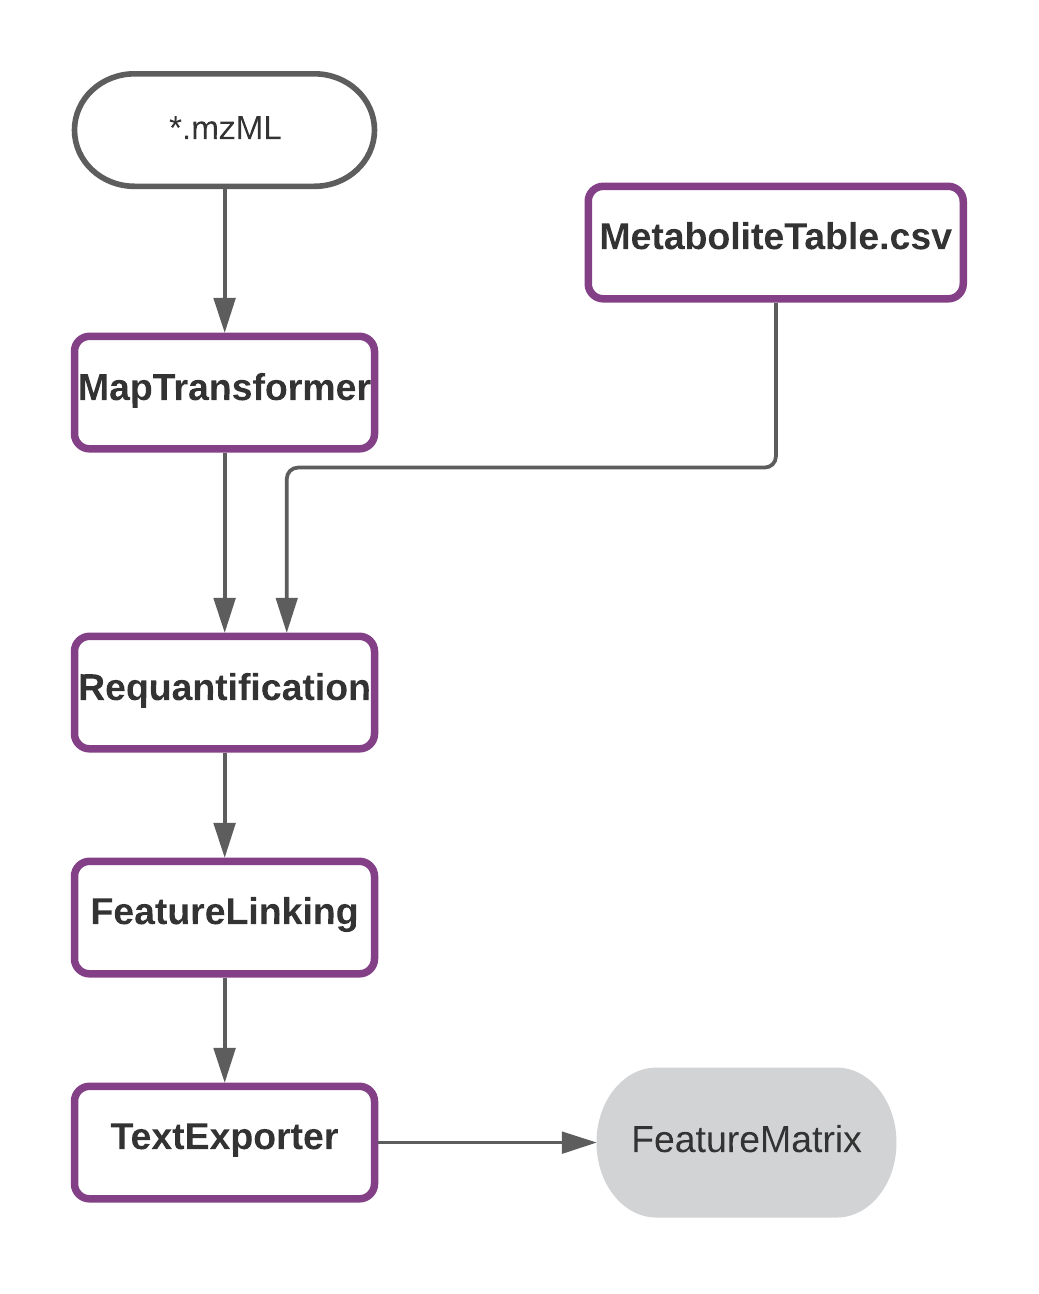

#### `1) Create a library (MetaboliteIdentification table)` 

The first step is to create a library of compounds derived from the features generated from all files in the pre-processing steps. 


In [2]:
#Import the consensus tsv table and keep only the columns: RT, mz and charge
DF_features = pd.read_csv("results/GNPSexport/interim/consensus.tsv", sep="\t")
DF_features = DF_features[['RT','mz', "charge"]]

#convert the mz and RT columns to floats and charge to integer for calculations
DF_features["charge"] = pd.to_numeric(DF_features["charge"], downcast="integer")
DF_features["mz"] = pd.to_numeric(DF_features["mz"], downcast="float")
DF_features["RT"] = pd.to_numeric(DF_features["RT"], downcast="float")

#Add a columns named "Mass" and calculate the neutral masses from the charge and mz:
DF_features["Mass"]= 0.0
for ind in DF_features.index:
    if DF_features["charge"][ind] == 0:
        DF_features.loc[ind, "Mass"]= DF_features.loc[ind,"mz"]
    if DF_features["charge"][ind] == 1:
        DF_features.loc[ind, "Mass"]= DF_features.loc[ind,"mz"]- 1.007825
    if DF_features["charge"][ind] == 2:
        DF_features.loc[ind, "Mass"]= (DF_features.loc[ind,"mz"]*2)- 2.015650
    if DF_features["charge"][ind] == 3:
        DF_features.loc[ind, "Mass"]= (DF_features.loc[ind,"mz"]*3)- 3.023475

#Rename columns to the required ones and add positive or negative sign for charge
DF_features= DF_features.rename(columns={"RT": "RetentionTime", "charge":"Charge"})
DF_features["Charge"]= DF_features["Charge"].astype(str)
for ind in DF_features.index:
    if DF_features["Charge"][ind] == "1":
        DF_features.loc[ind, "Charge"]= "+" + DF_features.loc[ind,"Charge"]
    if DF_features["Charge"][ind] == "2":
        DF_features.loc[ind, "Charge"]= "+" + DF_features.loc[ind,"Charge"]
    if DF_features["Charge"][ind] == "3":
        DF_features.loc[ind, "Charge"]= "+" + DF_features.loc[ind,"Charge"]
#drop the mz column
DF_features= DF_features.drop(columns= "mz")

#add the rest of the columns required for the MetaboliteIdentificationTable and fill with zeros or blanks, except the "Compound Name"
#which, since they are all unknown, can be filled with feature_#
DF_features['CompoundName'] = np.arange(len(DF_features))
DF_features['CompoundName'] = "feature_" + DF_features['CompoundName'].astype(str)
DF_features["SumFormula"] = " "
DF_features["RetentionTimeRange"]= "0"
DF_features["IsoDistribution"]= "0"
DF_features= DF_features[["CompoundName","SumFormula", "Mass","Charge","RetentionTime","RetentionTimeRange", "IsoDistribution"]]
DF_features.to_csv("resources/MetaboliteIdentification.tsv", sep="\t", index= None)
DF_features

,CompoundName,SumFormula,Mass,Charge,RetentionTime,RetentionTimeRange,IsoDistribution
0,feature_0,,227.162753,+1,91.263603,0,0
1,feature_1,,154.073687,+1,85.650543,0,0
2,feature_2,,431.230151,+1,526.956299,0,0
3,feature_3,,421.241870,+1,71.314590,0,0
4,feature_4,,227.187930,+1,474.451019,0,0
...,...,...,...,...,...,...,...
17941,feature_17941,,1060.566137,+2,306.633545,0,0
17942,feature_17942,,402.221655,+2,61.321491,0,0
17943,feature_17943,,1173.504736,+2,274.222290,0,0
17944,feature_17944,,2026.940893,+2,310.961517,0,0


#### `2) MapAlignmentTransformer`
This algorithm is used to perform a linear retention time alignment, in order to correct for chromatographic shifts in retention time. Use the trafo XML files from the feature alignment and align the raw spectra.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1MapAlignmentTransformer.html

In [10]:
input_mzml_files = sorted(glob.glob('results/interim/PCpeak_*.mzML'))
input_trafo = sorted(glob.glob('results/GNPSexport/interim/*.trafoXML'))

for filename in input_mzml_files:
    exp= MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    transformer = MapAlignmentTransformer()

    for trafo_XML in input_trafo:
        trafo=TransformationDescription()
        TransformationXMLFile().load(trafo_XML, trafo, True)
        if os.path.basename(trafo_XML)[11:-9] == os.path.basename(filename)[7:-5]:
            transformer.transformRetentionTimes(exp, trafo, True)
            mzml_file = os.path.join("results", "", "Requant", "", "interim", "", 'MapAligned_' + os.path.basename(exp.getLoadedFilePath())[7:-5] +".mzML")
            MzMLFile().store(mzml_file, exp)

#### `2) FeatureFinderMetaboIdent`
This algorithm detects and extracts MS1 data that match the feature list in the metabolite identification table.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/UTILS_FeatureFinderMetaboIdent.html

In [11]:
import csv
# read tsv file and create list of FeatureFinderMetaboIdentCompound
def metaboTableFromFile(path_to_library_file):
    metaboTable = []
    with open(path_to_library_file, 'r') as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter="\t")
        next(tsv_reader) # skip header
        for row in tsv_reader:
            metaboTable.append(FeatureFinderMetaboIdentCompound(
                row[0], # name
                row[1], # sum formula
                float(row[2]), # mass
                [int(charge) for charge in row[3].split(',')], # charges
                [float(rt) for rt in row[4].split(',')], # RTs
                [float(rt_range) for rt_range in row[5].split(',')], # RT ranges
                [float(iso_distrib) for iso_distrib in row[6].split(',')] # isotope distributions
            ))
    return metaboTable

In [12]:
input_mzml_files=sorted(glob.glob("results/Requant/interim/*.mzML"))
# load ms data from mzML file into MSExperiment
for mzml_file in input_mzml_files:
    spectra = MSExperiment()
    MzMLFile().load(mzml_file, spectra)

    # create FeatureFinderAlgorithmMetaboIdent and assign ms data
    ff = FeatureFinderAlgorithmMetaboIdent()
    ff.setMSData(spectra)

    # read library generate a metabo table with compounds
    metabo_table = metaboTableFromFile('resources/MetaboliteIdentification.tsv')

    params = ff.getParameters()
    params[b'extract:mz_window'] = 5.0 
    params[b'detect:peak_width'] = 20.0  #adjust for wide peaks
    ff.setParameters(params)
    # FeatureMap to store results
    fm = FeatureMap()
    # run the FeatureFinderMetaboIdent with the metabo_table and store results in fm
    ff.run(metabo_table, fm) #, String(mzml_file)

    # save FeatureMap to file
    ff_file = os.path.join("results", "", "Requant", "", "interim", "", 'FFMI_' + os.path.basename(mzml_file)[11:-5] +".featureXML")
    FeatureXMLFile().store(ff_file, fm)

Display the features as a dataframe:

In [ ]:
input_feature_files = sorted(glob.glob('results/Requant/interim/FFMI_*.featureXML'))

for filename in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df()
    feature_csv= os.path.join("results", "", "Requant", "", 'features_' +  os.path.basename(fmap.getMetaValue('spectra_data')[0].decode())[11:-5] +".csv")
    DF.to_csv(feature_csv)
    print(os.path.basename(filename))
    display(DF)

#### `3) FeatureGroupingAlgorithmKD `

Feature linker aggregates the feature information (from single files) into a ConsensusFeature, linking features from different files together, which have a smiliar m/z and rt (no MS2 data).

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FeatureLinkerUnlabeledKD.html

In [4]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMap()
file_descriptions = consensus_map.getColumnHeaders()

input_feature_files = sorted(glob.glob('results/Requant/interim/*.featureXML'))

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[34:-5]
    file_description.size = feature_map.size()
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)

Consensus_file= os.path.join("results", "", "Requant", "","interim", "", 'consensus' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, consensus_map)

# get intensities as a DataFrame
result = consensus_map.get_df()
result= result.reset_index()
result= result.drop(columns= ["id", "sequence", "quality"])
# store as tsv file
result.to_csv('results/Requant/FeatureMatrix.tsv', sep = '\t', index = False)
result

['results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML', 'results/Requant/interim/FFMI_20210827_UMETAB219_POS

### Compare the preprocessed and requantified numbers of features (missing values):

In [3]:
from pyopenms import *
import pandas as pd
import os
import glob

Preprocessed= glob.glob("results/features/*.csv")
Requantified= glob.glob("results/Requant/*.csv")

for table in Preprocessed:
    df1= pd.read_csv(table)
    feature_no= len(df1)

    for matrix in Requantified:
        df2= pd.read_csv(matrix)
        requant_no= len(df2)

        if os.path.basename(table)== os.path.basename(matrix):
            print(os.path.basename(matrix))
            print("Preprocessed:", feature_no, "Requantified:", requant_no)
   

features_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.csv
Preprocessed: 1267 Requantified: 5294
features_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.csv
Preprocessed: 623 Requantified: 4467
features_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.csv
Preprocessed: 556 Requantified: 4451
features_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.csv
Preprocessed: 543 Requantified: 4923
features_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.csv
Preprocessed: 523 Requantified: 4068
features_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.csv
Preprocessed: 3008 Requantified: 5045
features_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.csv
Preprocessed: 532 Requantified: 3807
features_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.csv
Preprocessed: 636 Requantified: 3936
features_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.csv
Preprocessed: 2436 Requantified: 6625
features_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.csv
Preprocessed: 2350 